In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats
import tarfile as tar
import requests
import json
import re
import glob #for file import

In [25]:
# In order to get the full information, let's display always the entire df
pd.set_option('display.max_rows', None, 'display.max_columns', None)

# Part I: Data acquisition, formatting and clean-up

## Available data of the TCGA

The TCGA represents the most important medical database on cancer worldwide. It includes extensive clinical and sequencing data about patients suffering from cancers. All cancer entities have been included.

We will be working with patients suffering from primary non-small cell lung cancer. Furthermore, we will focus only on patients suffering from __lung adenocarcinoma__ or __lung squamous cell carcinoma__ which represent the most prevalent histological entities.

TCGA data can be accessed via the _GDC (Genomic Data Commons) Data portal_. This portal includes mainly sequencing information but also clinical information and for some cases scanned histological images. _Python_ can be used to retrieve easily data from the GDC API in order to use it for downstream analyses.

In [ ]:
# Script from official GDC TCGA site -> best way to query files via python based on a filtered search

files_endpt = "https://api.gdc.cancer.gov/files"

'''Filters adapted to the receive the exact files for further analyses -> clinical data on lung cancer cases. Only
adeno- and squamous cell carcinomas, tab separated txt-files from patients with known status (dead or alive).
''' 

filters = {
    "op": "and",
    "content":[
        {
        "op": "in",
        "content":{
            "field": "cases.demographic.vital_status",
            "value": ["alive", "dead"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "cases.disease_type",
            "value": ["adenomas and adenocarcinomas", "squamous cell neoplasms"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "cases.primary_site",
            "value": ["bronchus and lung"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "files.data_category",
            "value": ["clinical"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "files.data_format",
            "value": ["bcr biotab"]
            }
        }
    ]
}

# Here a GET is used, so the filter parameters should be passed as a JSON string.

params = {
    "filters": json.dumps(filters),
    "fields": "file_id",
    "format": "JSON",
    "size": "1000"
    }

response = requests.get(files_endpt, params = params)

file_uuid_list = []

# This step populates the download list with the file_ids from the previous query
for file_entry in json.loads(response.content.decode("utf-8"))["data"]["hits"]:
    file_uuid_list.append(file_entry["file_id"])

data_endpt = "https://api.gdc.cancer.gov/data"

params = {"ids": file_uuid_list}

response = requests.post(data_endpt, data = json.dumps(params), headers = {"Content-Type": "application/json"})

response_head_cd = response.headers["Content-Disposition"]

file_name = re.findall("filename=(.+)", response_head_cd)[0]

with open(file_name, "wb") as output_file:
    output_file.write(response.content)

In [ ]:
for f in glob.glob('./gdc_download_*.tar.gz'):
    tar = tar.open(f)
    tar.extractall(path = './TCGA')
    tar.close()

In [4]:
all_dfs = []
for i, filename in enumerate(glob.glob('./TCGA/*/*.txt')):
   with open(os.path.join(os.getcwd(), filename), 'r') as f:
    all_dfs.append(pd.read_csv(filepath_or_buffer = filename, sep = "\t"))

In [6]:
for df in all_dfs:
    df.drop([0,1], axis = 0, inplace = True

In [10]:
all_TGCA_df = all_dfs.pop(0)
all_TGCA_df = all_TGCA_df.append(all_dfs)
all_TGCA_df

,bcr_patient_uuid,bcr_patient_barcode,form_completion_date,prospective_collection,gender,histologic_diagnosis,ethnicity,retrospective_collection,tobacco_smoking_year_started,tobacco_smoking_year_stopped,...,eml4_alk_translocation_identified,family_member_relationship_type,margin_status,measure_of_response,metastatic_site_at_diagnosis,metastatic_site_at_diagnosis_other,number_cycles,prior_systemic_therapy_type,regimen_indication,relative_family_cancer_history
2,95b83006-02c9-4c4d-bf84-a45115f7d86d,TCGA-18-3406,2011-3-9,NO,MALE,Lung Squamous Cell Carcinoma,NOT HISPANIC OR LATINO,YES,1951,[Not Available],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4e1ad82e-23c8-44bb-b74e-a3d0b1126b96,TCGA-18-3407,2011-3-9,NO,MALE,Lung Squamous Cell Carcinoma,NOT HISPANIC OR LATINO,YES,[Not Available],1988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d4bc755a-2585-4529-ae36-7e1d88bdecfe,TCGA-18-3408,2011-3-9,NO,FEMALE,Lung Squamous Cell Carcinoma,NOT HISPANIC OR LATINO,YES,[Not Available],2004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,b09e872a-e837-49ec-8a27-84dcdcabf347,TCGA-18-3409,2011-3-17,NO,MALE,Lung Squamous Cell Carcinoma,NOT HISPANIC OR LATINO,YES,[Not Available],1974,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,99599b60-4f5c-456b-8755-371b1aa7074e,TCGA-18-3410,2011-4-4,NO,MALE,Lung Squamous Cell Carcinoma,[Not Available],YES,[Not Available],[Not Available],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,F2E35FFC-C87A-4E42-9C8D-E7E5D8B49D87,TCGA-NK-A5CT,2013-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
567,F2E35FFC-C87A-4E42-9C8D-E7E5D8B49D87,TCGA-NK-A5CT,2015-3-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
568,5B3CB83B-CFDE-42DC-A6EC-0127BD0E6685,TCGA-NK-A5CX,2013-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
569,80AA8E99-41D5-422F-A1BB-69599AA8236F,TCGA-NK-A5D1,2013-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_TCGA_subset =df_TCGA_full[["bcr_patient_uuid", "histologic_diagnosis", "history_neoadjuvant_treatment", "last_contact_days_to","ajcc_pathologic_tumor_stage", "death_days_to", "vital_status"]]

df_TCGA_subset.head(100)

In [28]:
df_TCGA_2

,bcr_patient_uuid,bcr_patient_barcode,bcr_followup_barcode,bcr_followup_uuid,form_completion_date,vital_status,followup_reason,followup_lost_to,radiation_treatment_adjuvant,pharmaceutical_tx_adjuvant,last_contact_days_to,treatment_outcome_first_course,death_days_to,new_tumor_event_dx_indicator,tumor_status,new_tumor_event_type,karnofsky_score,ecog_score,performance_status_timing,new_tumor_event_dx_days_to,new_tumor_event_radiation_tx,new_tumor_event_dx_evidence,new_tumor_event_pharmaceutical_tx,new_tumor_event_surgery,new_tumor_event_surgery_days_to_loco,new_tumor_event_surgery_met,new_tumor_event_surgery_days_to_met,treatment_outcome_at_tcga_followup
0,bcr_patient_uuid,bcr_patient_barcode,bcr_followup_barcode,bcr_followup_uuid,form_completion_date,vital_status,followup_case_report_form_submission_reason,lost_follow_up,radiation_therapy,postoperative_rx_tx,days_to_last_followup,primary_therapy_outcome_success,days_to_death,new_tumor_event_after_initial_treatment,person_neoplasm_cancer_status,new_neoplasm_event_type,karnofsky_performance_score,eastern_cancer_oncology_group,performance_status_scale_timing,days_to_new_tumor_event_after_initial_treatment,additional_radiation_therapy,progression_determined_by,additional_pharmaceutical_therapy,additional_surgery_locoregional_procedure,days_to_additional_surgery_locoregional_procedure,additional_surgery_metastatic_procedure,days_to_additional_surgery_metastatic_procedure,followup_treatment_success
1,CDE_ID:,CDE_ID:2003301,CDE_ID:,CDE_ID:,CDE_ID:,CDE_ID:5,CDE_ID:3233305,CDE_ID:61333,CDE_ID:2005312,CDE_ID:3397567,CDE_ID:3008273,CDE_ID:2786727,CDE_ID:3165475,CDE_ID:3121376,CDE_ID:2759550,CDE_ID:3119721,CDE_ID:2003853,CDE_ID:88,CDE_ID:2792763,CDE_ID:3392464,CDE_ID:3427615,CDE_ID:2786205,CDE_ID:3427616,CDE_ID:3008755,CDE_ID:3408572,CDE_ID:3008757,CDE_ID:3408682,CDE_ID:3104050
2,03d09c05-49ab-4ba6-a8d7-e7ccf71fafd2,TCGA-05-4245,TCGA-05-4245-F36308,8B6363A9-C846-48D4-8051-2A0B97BAD585,2012-10-29,Alive,Scheduled Follow-up Submission,NO,NO,NO,730,[Not Applicable],[Not Applicable],YES,TUMOR FREE,[Not Available],[Not Available],[Not Available],[Not Available],334,NO,[Not Available],NO,[Not Available],[Not Available],[Not Available],[Not Available],Complete Remission/Response
3,4addf05f-3668-4b3f-a17f-c0227329ca52,TCGA-05-4249,TCGA-05-4249-F36327,485963A2-753D-4E86-B3DF-E3F66189ABEE,2012-10-29,Alive,Scheduled Follow-up Submission,NO,NO,NO,1523,[Not Applicable],[Not Applicable],NO,TUMOR FREE,[Not Available],[Not Available],[Not Available],[Not Available],[Not Applicable],[Not Available],[Not Available],[Not Available],[Not Available],[Not Applicable],[Not Available],[Not Applicable],Complete Remission/Response
4,3434b91a-c05f-460f-a078-7b1bb6e7085d,TCGA-05-4382,TCGA-05-4382-F36329,A8CCFEBD-82AA-41E1-85E0-75E97DEA2051,2012-10-29,Alive,Scheduled Follow-up Submission,NO,YES,NO,607,Complete Remission/Response,[Not Applicable],YES,TUMOR FREE,Distant Metastasis,[Not Available],[Not Available],[Not Available],334,YES,[Not Available],[Unknown],[Not Available],[Not Available],[Not Available],[Not Available],Complete Remission/Response
5,9a50e7e4-831d-489f-87d2-979e987561cc,TCGA-05-4384,TCGA-05-4384-F36330,F4555A19-ABBE-4673-9871-083B5C01710A,2012-10-29,Alive,Scheduled Follow-up Submission,NO,YES,YES,426,Progressive Disease,[Not Applicable],YES,WITH TUMOR,Distant Metastasis,[Not Available],[Not Available],[Not Available],183,YES,[Not Available],[Unknown],[Not Available],[Not Available],[Not Available],[Not Available],Progressive Disease
6,a3de401d-91fe-49a2-bb07-81c1a06506e6,TCGA-05-4389,TCGA-05-4389-F36455,A2734A4F-5C1D-4D7B-B01D-01305FF9E917,2012-10-31,Alive,Scheduled Follow-up Submission,NO,NO,NO,1369,[Not Applicable],[Not Applicable],NO,TUMOR FREE,[Not Available],[Not Available],[Not Available],[Not Available],[Not Applicable],[Not Available],[Not Available],[Not Available],[Not Available],[Not Applicable],[Not Available],[Not Applicable],Complete Remission/Response
7,b8475929-2d9d-4909-bd62-59684a140b

## Available data from the Bernese cohort

The Bernese cohort was assembled in order to study potential biomarkers in lung cancer patients which received neoadjuvant treatment. The initial cohort was assembled using the digital pathological file system of the _Institute of Pathology_ of the _University of Bern_. The study cohort consists of resections obtained after neoadjuvant therapy and this cohort was matched to a control cohort of primary resections of lung adeno- or squamous cell carcinoma. The whole dataset is available as a _.csv_ file.

In [11]:
# For all further survival analyses, we need additionally the timespan (i.e. month until death or last follow up)
df = pd.read_csv('/Users/philipp/Documents/University/CAS_ADS/Module_2/RAW_DatasetNeoadjuvantCancers_20200910.csv', sep = ';', header = 0)
df['start_date'] = pd.to_datetime(df['ED'], dayfirst = True)
df['stop_date_OS'] = pd.to_datetime(df['LFU'], dayfirst = True)
df['OS'] = ((df['stop_date_OS'] - df['start_date']) / np.timedelta64(1, 'M'))
df

,PID,AGE,SEX,SMOKING,HISTO,BED,VITAL,pT_TNM8,pN_TNM8,pM_TNM8,...,ADJ,RELAPSE,RELDATE,STATOS,STATDFS,ED,LFU,start_date,stop_date_OS,OS
0,1,79.0,2.0,1.0,1,6.0,60.0,30.0,11.0,0,...,0.0,0.0,NaN,0.0,0.0,23.09.03,05.08.04,2003-09-23,2004-08-05,10.414998
1,2,74.0,2.0,NaN,2,4.5,90.0,22.0,211.0,0,...,4.0,2.0,03.12.01,1.0,1.0,14.02.01,22.07.02,2001-02-14,2002-07-22,17.183104
2,4,76.0,2.0,2.0,1,3.0,0.5,13.0,12.0,0,...,0.0,NaN,NaN,0.0,0.0,06.10.03,22.03.04,2003-10-06,2004-03-22,5.519621
3,5,77.0,2.0,2.0,1,2.3,20.0,40.0,11.0,0,...,NaN,0.0,NaN,1.0,1.0,17.08.05,14.12.05,2005-08-17,2005-12-14,3.909731
4,6,77.0,2.0,NaN,2,2.3,80.0,13.0,211.0,0,...,NaN,0.0,NaN,1.0,1.0,03.08.06,07.08.06,2006-08-03,2006-08-07,0.131420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,247,52.0,2.0,1.0,1,8.3,0.0,40.0,2.0,0,...,NaN,NaN,NaN,1.0,1.0,13.11.15,31.01.16,2015-11-13,2016-01-31,2.595536
242,248,46.0,2.0,2.0,1,2.4,0.0,13.0,2.0,0,...,1.0,0.0,NaN,0.0,0.0,26.11.15,23.10.19,2015-11-26,2019-10-23,46.883920
243,249,39.0,2.0,1.0,1,10.5,0.0,40.0,2.0,0,...,1.0,0.0,NaN,1.0,1.0,21.03.16,14.10.16,2016-03-21,2016-10-14,6.800961
244,250,84.0,1.0,1.0,1,5.0,0.0,22.0,2.0,0,...,0.0,0.0,NaN,1.0,1.0,24.06.05,16.04.08,2005-06-24,2008-04-16,33.741966


In [12]:
# We see that one case does not have an age -> This was a second tumor in the same patients and should not be used for further analyses
df_invalid_DOB = df[df['AGE'].isna()]
df_invalid_DOB
df = df.dropna(subset = ['AGE'])

In [13]:
# Cases with NEOCAT = 2 are excluded. They received treatment prior resection but not in neoadjuvant intention.
df_valid = df[df['NEOCAT'] != 2]
# Most of the following analyses will compare the study and control cohort. We will thus create a clearer grouping variable.
conditions_treatment = [
    (df_valid['NEOCAT'] < 3),
    (df_valid['NEOCAT'] == 3)
]
values_treatment = ['Neoadjuvant', 'Primary']
df_valid['group'] = np.select(conditions_treatment, values_treatment)
df_valid

<ipython-input-13-a1629d2a0bb3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['group'] = np.select(conditions_treatment, values_treatment)


,PID,AGE,SEX,SMOKING,HISTO,BED,VITAL,pT_TNM8,pN_TNM8,pM_TNM8,...,RELAPSE,RELDATE,STATOS,STATDFS,ED,LFU,start_date,stop_date_OS,OS,group
1,2,74.0,2.0,NaN,2,4.5,90.0,22.0,211.0,0,...,2.0,03.12.01,1.0,1.0,14.02.01,22.07.02,2001-02-14,2002-07-22,17.183104,Neoadjuvant
2,4,76.0,2.0,2.0,1,3.0,0.5,13.0,12.0,0,...,NaN,NaN,0.0,0.0,06.10.03,22.03.04,2003-10-06,2004-03-22,5.519621,Neoadjuvant
3,5,77.0,2.0,2.0,1,2.3,20.0,40.0,11.0,0,...,0.0,NaN,1.0,1.0,17.08.05,14.12.05,2005-08-17,2005-12-14,3.909731,Neoadjuvant
4,6,77.0,2.0,NaN,2,2.3,80.0,13.0,211.0,0,...,0.0,NaN,1.0,1.0,03.08.06,07.08.06,2006-08-03,2006-08-07,0.131420,Neoadjuvant
5,7,72.0,2.0,2.0,1,9.0,90.0,40.0,22.0,0,...,0.0,NaN,1.0,1.0,18.04.02,10.09.02,2002-04-18,2002-09-10,4.763958,Neoadjuvant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,246,57.0,1.0,NaN,1,7.2,0.0,40.0,2.0,0,...,NaN,NaN,1.0,1.0,11.02.16,09.10.16,2016-02-11,2016-10-09,7.918027,Primary
241,247,52.0,2.0,1.0,1,8.3,0.0,40.0,2.0,0,...,NaN,NaN,1.0,1.0,13.11.15,31.01.16,2015-11-13,2016-01-31,2.595536,Primary
242,248,46.0,2.0,2.0,1,2.4,0.0,13.0,2.0,0,...,0.0,NaN,0.0,0.0,26.11.15,23.10.19,2015-11-26,2019-10-23,46.883920,Primary
243,249,39.0,2.0,1.0,1,10.5,0.0,40.0,2.0,0,...,0.0,NaN,1.0,1.0,21.03.16,14.10.16,2016-03-21,2016-10-14,6.800961,Primary


# Part II: Data Analysis

## Comparison of the _study_ and _control_ cohort

In [ ]:
# The control cohort does include only adeno- or squamous cell carcinomas. For comparison, we will thus exclude all neoadjuvant cases with other histology than LUAD or LUSC
df_comparison = df_valid[df_valid['HISTO'] < 3].dropna(subset = ['STATOS'])

### Categorical variables - data clean up & category merging

In [ ]:
# Some of the categorical variables have a lot of small categories. We will look at these in order to decide which one to simplify
for column in df_comparison[['pT_TNM8', 'Stage_TNM8', 'SMOKING', 'RTYPE', 'R', 'ADJ']]:
    print(pd.crosstab(index = df_comparison[column], columns = df_comparison['group']))
    print()

In [ ]:
# Cases with no curative resection RTYPE = 1 or without any information about the completeness of the resection need to be excluded
df_testing = df_comparison[df_comparison['R'] != 3]
df_testing = df_testing[df_testing['RTYPE'] != 1]

In [ ]:
# Most important pT categories are 0, 1, 2, 3 and 4. We don't need all other subcategories
conditions_pT = [
    (df_testing['pT_TNM8'] < 10),
    (df_testing['pT_TNM8'] < 20),
    (df_testing['pT_TNM8'] < 30),
    (df_testing['pT_TNM8'] < 40),
    (df_testing['pT_TNM8'] == 40)
]
values_pT = ['pT0', 'pT1', 'pT2', 'pT3', 'pT4']
df_testing['pT_short'] = np.select(conditions_pT, values_pT)

conditions_stage = [
    (df_testing['Stage_TNM8'] < 100),
    (df_testing['Stage_TNM8'] < 200),
    (df_testing['Stage_TNM8'] < 300),
    (df_testing['Stage_TNM8'] < 400),
    (df_testing['Stage_TNM8'] >= 400)
]
values_stage = ['Stage 0', 'Stage I', 'Stage II', 'Stage III', 'Stage IV']
df_testing['stage_short'] = np.select(conditions_stage, values_stage)

In [ ]:
# Upper or lower bilobectomy are equally extensive, hence, we combine these
conditions_RTYPE = [
    (df_testing['RTYPE'] == 3),
    (df_testing['RTYPE'] < 6),
    (df_testing['RTYPE'] == 6)
]
values_RTYPE = [1, 2, 3]
df_testing['rtype_short'] = np.select(conditions_RTYPE, values_RTYPE)

conditions_R = [
    (df_testing['R'] == 0),
    (df_testing['R'] > 0)
]
values_R = [0, 1]
df_testing['R_short'] = np.select(conditions_R, values_R)

In [ ]:
# We are only interested if the patients received adjuvant therapy after resection or not
conditions_adjuvant = [
    (df_testing['ADJ'] == 0),
    (df_testing['ADJ'] < 4),
    (df_testing['ADJ'] == 4),
    (df_testing['ADJ'] == 5)
]
values_adjuvant = [0, 1, 0, 1]

df_testing['adjuvant_short'] = np.select(conditions_adjuvant, values_adjuvant)
df_testing

### Categorical variables - testing

In [ ]:
# pT- and stage-variable have a natural order (higher categories = more aggressive). We use the Mann-Whitney-U
df_testing_study = df_testing[df_testing['group'] == 'Neoadjuvant']
df_testing_control = df_testing[df_testing['group'] == 'Primary']

for column in df_testing[['pT_short', 'stage_short']]:
    stat, p = scipy.stats.mannwhitneyu(df_testing_study[column], df_testing_control[column])
    print('Statistics = {0:.2f}, p-value = {1:.3f}'.format(stat, p))

In [ ]:
# The difference could probably be explained by the fact that treated cases can have no more tumor. Hence, we exclude cases with pT0 or stage 0
df_testing_withoutpT0 = df_testing[df_testing['pT_short'] != 'pT0']
df_testing_study_withoutpT0 = df_testing_withoutpT0[df_testing['group'] == 'Neoadjuvant']
df_testing_control_withoutpT0 = df_testing_withoutpT0[df_testing['group'] == 'Primary']

df_testing_withoutstage0 = df_testing[df_testing['stage_short'] != 'Stage 0']
df_testing_study_withoutstage0 = df_testing_withoutstage0[df_testing['group'] == 'Neoadjuvant']
df_testing_control_withoutstage0 = df_testing_withoutstage0[df_testing['group'] == 'Primary']

stat_pT, p_pT = scipy.stats.mannwhitneyu(df_testing_study_withoutpT0['pT_short'], df_testing_control_withoutpT0['pT_short'])
print('Statistics = {0:.2f}, p-value = {1:.3f}'.format(stat_pT, p_pT))

stat_stage, p_stage = scipy.stats.mannwhitneyu(df_testing_study_withoutstage0['stage_short'], df_testing_control_withoutstage0['stage_short'])
print('Statistics = {0:.2f}, p-value = {1:.3f}'.format(stat_stage, p_stage))

In [ ]:
crosstab_pT = pd.crosstab(index = df_testing_withoutpT0['group'], columns = df_testing_withoutpT0['pT_short'])
crosstab_proportion_pT = crosstab_pT.apply(lambda x: x*100/sum(x), axis=1)
crosstab_proportion_pT.plot.bar(stacked=True)
plt.xlabel('Treatment Group')
plt.ylabel('Proportion %')
plt.title('Comparison of pT categories between treatment groups')

In [ ]:
crosstab_stage = pd.crosstab(index = df_testing_withoutstage0['group'], columns = df_testing_withoutstage0['stage_short'])
crosstab_proportion_stage = crosstab_stage.apply(lambda x: x*100/sum(x), axis=1)
crosstab_proportion_stage.plot.bar(stacked=True)
plt.xlabel('Treatment Group')
plt.ylabel('Proportion %')
plt.title('Comparison of stage categories between treatment groups')

In [ ]:
# Completeness of resection and adjuvant therapy are binary -> Fisher's exact
# Adjuvant therapy
crosstab_adjuvant = pd.crosstab(index = df_testing['adjuvant_short'], columns = df_testing['group'])
fisher_table_adjuvant = crosstab_adjuvant.to_numpy()
stats_adjuvant, p_adjuvant = scipy.stats.fisher_exact(fisher_table_adjuvant)

print('Adjuvant Statistic: {0:.2f}, Adjuvant p-value: {1:.3f}'.format(stats_adjuvant, p_adjuvant))
crosstab_adjuvant

In [ ]:
# Completeness of resection
crosstab_R = pd.crosstab(index = df_testing['R_short'], columns = df_testing['group'])
fisher_table_R = crosstab_R.to_numpy()
stats_R, p_R = scipy.stats.fisher_exact(fisher_table_R)

print('Completeness Statistic: {0:.2f}, Completeness p-value: {1:.3f}'.format(stats_R, p_R))
crosstab_R

In [ ]:
# Resection type and smoking status are categorical without order -> Chi^2 test
# Smoking
crosstab_Smoking = pd.crosstab(index = df_testing['SMOKING'], columns = df_testing['group'])
chisquare_table_Smoking = crosstab_Smoking.to_numpy()
chi2_Smoking, p_Smoking, dof, expected = scipy.stats.chi2_contingency(chisquare_table_Smoking)

print('Smoking Statistic: {0:.2f}, Smoking p-value: {1:.3f}'.format(chi2_Smoking, p_Smoking))
crosstab_Smoking

In [ ]:
# Resection type
crosstab_Rtype = pd.crosstab(index = df_testing['rtype_short'], columns = df_testing['group'])
chisquare_table_Rtype = crosstab_Rtype.to_numpy()
chi2_Rtype, p_Rtype, dof, expected = scipy.stats.chi2_contingency(chisquare_table_Rtype)

print('Smoking Statistic: {0:.2f}, Smoking p-value: {1:.3f}'.format(chi2_Rtype, p_Rtype))
crosstab_Rtype

### Continuous variables - testing

In [ ]:
# First visually check if the data is normally distributed
ax_1 = plt.hist(df_testing_study['AGE'], 10, density = 1, facecolor = 'g', alpha = 0.5, label = 'Study Cohort')
ax_2 = plt.hist(df_testing_control['AGE'], 10, density = 1, facecolor = 'r', alpha = 0.5, label = 'Control Cohort')
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# We check if it's possible to use the students t or if we need to use the Welch
var_study = np.var(df_testing_study['AGE'])
mean_study = np.mean(df_testing_study['AGE'])
size_study = len(df_testing_study.index)
var_control = np.var(df_testing_control['AGE'])
mean_control = np.mean(df_testing_control['AGE'])
size_control = len(df_testing_control.index)

print('The study cohort has a mean age of {0:.2f} and a variance of {1:.2f}. A total of {2} cases.'.format(mean_study, var_study, size_study))
print('The control cohort has a mean age of {0:.2f} and a variance of {1:.2f}. A total of {2} cases.'.format(mean_control, var_control, size_control))

In [ ]:
# All requirements are fulfilled -> perform the statistical test
stats_age, p_age = scipy.stats.ttest_ind(df_testing_study['AGE'], df_testing_control['AGE'])
print('Statistics = {0:.2f} and p-value = {1:.3f}'.format(stats_age, p_age))

In [ ]:
# Visually check normal distribution
ax_histobed1 = plt.hist(df_testing_study['BED'], 10, density = 1, facecolor = 'g', alpha = 0.5, label = 'Study Cohort')
ax_histobed2 = plt.hist(df_testing_control['BED'], 10, density = 1, facecolor = 'r', alpha = 0.5, label = 'Control Cohort')
plt.xlabel('Tumor bed size [cm]')
plt.ylabel('Density')
plt.title('Age Distribution')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Requirement of normal distribution is not fulfilled
stats_bed, p_bed = scipy.stats.mannwhitneyu(df_testing_study['BED'], df_testing_control['BED'])
print('Statistics = {0:.2f} and p-value = {1:.3f}'.format(stats_bed, p_bed))

In [ ]:
# There is a statistical difference, however, the non-parametric tests are significance driven -> visual check
data_boxplot = [df_testing_study['BED'], df_testing_control['BED']]
fig_box, ax_box = plt.subplots()
ax_box.set_title('Comparison of tumor bed size between groups')
ax_box.boxplot(data_boxplot, labels = ['Neoadjuvant', 'Primary'])
plt.xlabel('Treatment group')
plt.ylabel('Tumor bed size [cm]')
plt.grid(True)
plt.show

### Survival comparison

In [17]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [ ]:
T_comparison = df_testing['OS']
E_comparison = df_testing['STATOS']
kmf.fit(T_comparison, E_comparison, label = 'Overall')

In [ ]:
kmf.plot_survival_function(at_risk_counts = True)
plt.title('Overall Survival of the entire cohort')
plt.grid(True)
plt.tight_layout()

In [ ]:
ax_neovspr = plt.subplot(111)
neoadjuvant = (df_testing['group'] == 'Neoadjuvant')

kmf.fit(T_comparison[neoadjuvant], E_comparison[neoadjuvant], label = 'Neoadjuvant')
kmf.plot_survival_function(ax = ax_neovspr)

kmf.fit(T_comparison[~neoadjuvant], E_comparison[~neoadjuvant], label = 'Primary')
kmf.plot_survival_function(ax = ax_neovspr)
plt.title('Overall Survival according to treatment group')
plt.grid(True)

In [ ]:
# From the Kaplan-Meier plot it seems that neoadjuvant cases have a better survival -> let's test it
from lifelines.statistics import logrank_test
T_neoadjuvant = T_comparison[neoadjuvant]
E_neoadjuvant = E_comparison[neoadjuvant]
T_primary = T_comparison[~neoadjuvant]
E_primary = E_comparison[~neoadjuvant]

results = logrank_test(T_neoadjuvant, T_primary, event_observed_A = E_neoadjuvant, event_observed_B = E_primary)
print('Statistics = {0:.2f}, p-value = {1:.3f}.'.format(results.test_statistic, results.p_value))

## Survival prediction for neoadjuvant cases

In [14]:
df_study_survivalanalyses = df_valid[df_valid['group'] == 'Neoadjuvant'].dropna(subset = ['VITAL', 'STATOS'])
df_study_survivalanalyses = df_study_survivalanalyses[df_study_survivalanalyses['Stage_TNM8'] < 400]
df_study_survivalanalyses

,PID,AGE,SEX,SMOKING,HISTO,BED,VITAL,pT_TNM8,pN_TNM8,pM_TNM8,...,RELAPSE,RELDATE,STATOS,STATDFS,ED,LFU,start_date,stop_date_OS,OS,group
1,2,74.0,2.0,NaN,2,4.5,90.0,22.0,211.0,0,...,2.0,03.12.01,1.0,1.0,14.02.01,22.07.02,2001-02-14,2002-07-22,17.183104,Neoadjuvant
2,4,76.0,2.0,2.0,1,3.0,0.5,13.0,12.0,0,...,NaN,NaN,0.0,0.0,06.10.03,22.03.04,2003-10-06,2004-03-22,5.519621,Neoadjuvant
3,5,77.0,2.0,2.0,1,2.3,20.0,40.0,11.0,0,...,0.0,NaN,1.0,1.0,17.08.05,14.12.05,2005-08-17,2005-12-14,3.909731,Neoadjuvant
4,6,77.0,2.0,NaN,2,2.3,80.0,13.0,211.0,0,...,0.0,NaN,1.0,1.0,03.08.06,07.08.06,2006-08-03,2006-08-07,0.131420,Neoadjuvant
5,7,72.0,2.0,2.0,1,9.0,90.0,40.0,22.0,0,...,0.0,NaN,1.0,1.0,18.04.02,10.09.02,2002-04-18,2002-09-10,4.763958,Neoadjuvant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,126,48.0,1.0,2.0,2,3.5,15.0,13.0,0.0,0,...,5.0,14.01.17,1.0,1.0,14.01.16,25.06.18,2016-01-14,2018-06-25,29.339411,Neoadjuvant
125,127,46.0,2.0,1.0,1,2.8,90.0,21.0,22.0,0,...,0.0,NaN,1.0,1.0,08.05.16,07.07.18,2016-05-08,2018-07-07,25.955358,Neoadjuvant
126,128,44.0,2.0,0.0,2,4.8,70.0,30.0,22.0,0,...,0.0,NaN,1.0,1.0,29.02.16,24.09.16,2016-02-29,2016-09-24,6.833816,Neoadjuvant
144,147,59.0,2.0,NaN,2,2.0,10.0,30.0,22.0,0,...,0.0,NaN,0.0,0.0,01.10.00,02.09.02,2000-10-01,2002-09-02,23.031274,Neoadjuvant


In [40]:
# Age, stage, type of resection, completeness of resection and pathological response could be important prognostic factors
conditions_stage = [
    (df_study_survivalanalyses['Stage_TNM8'] < 100),
    (df_study_survivalanalyses['Stage_TNM8'] < 200),
    (df_study_survivalanalyses['Stage_TNM8'] < 300),
    (df_study_survivalanalyses['Stage_TNM8'] < 400)
]
values_stage = ['Stage 0', 'Stage I', 'Stage II', 'Stage III']
df_study_survivalanalyses['stage_short'] = np.select(conditions_stage, values_stage)

conditions_RTYPE = [
    (df_study_survivalanalyses['RTYPE'] == 3),
    (df_study_survivalanalyses['RTYPE'] < 6),
    (df_study_survivalanalyses['RTYPE'] == 6)
]
values_RTYPE = [1, 2, 3]
df_study_survivalanalyses['rtype_short'] = np.select(conditions_RTYPE, values_RTYPE)

conditions_R = [
    (df_study_survivalanalyses['R'] == 0),
    (df_study_survivalanalyses['R'] > 0)
]
values_R = [0, 1]
df_study_survivalanalyses['R_short'] = np.select(conditions_R, values_R)

# Let's create a variable which defines major pathological response based on the histology
df_study_survivalanalyses['MPR'] = ((df_study_survivalanalyses['HISTO'] == 2) & (df_study_survivalanalyses['VITAL'] <= 65)) | ((df_study_survivalanalyses['HISTO'] != 2) & (df_study_survivalanalyses['VITAL'] <= 10))
conditions_MPR = [
    (df_study_survivalanalyses['MPR'] == True),
    (df_study_survivalanalyses['MPR'] != True)
]
values_MPR = ['MPR', 'No-MPR']
df_study_survivalanalyses['MPR'] = np.select(conditions_MPR, values_MPR)
df_study_survivalanalyses

,PID,AGE,SEX,SMOKING,HISTO,BED,VITAL,pT_TNM8,pN_TNM8,pM_TNM8,Stage_TNM8,REG,NEOCAT,NEOCTX,NEOCYCLES,NEOCTXCHANGE,NEORTX,NEOSTART,NEOSTOP,RESECTION,RTYPE,R,ADJ,RELAPSE,RELDATE,STATOS,STATDFS,ED,LFU,start_date,stop_date_OS,OS,group,stage_short,rtype_short,R_short,MPR,new_MPR
1,2,74.0,2.0,NaN,2,4.5,90.0,22.0,211.0,0,310.0,4.0,0,1.0,4.0,2.0,0.0,14.02.01,11.04.01,10.05.01,3.0,0.0,4.0,2.0,03.12.01,1.0,1.0,14.02.01,22.07.02,2001-02-14,2002-07-22,17.183104,Neoadjuvant,Stage III,1,0,No-MPR,No-MPR
2,4,76.0,2.0,2.0,1,3.0,0.5,13.0,12.0,0,220.0,1.0,1,1.0,3.0,0.0,1.0,06.10.03,09.12.03,05.02.04,6.0,1.0,0.0,NaN,NaN,0.0,0.0,06.10.03,22.03.04,2003-10-06,2004-03-22,5.519621,Neoadjuvant,Stage II,3,1,MPR,MPR
3,5,77.0,2.0,2.0,1,2.3,20.0,40.0,11.0,0,310.0,3.0,1,1.0,3.0,1.0,0.0,17.08.05,19.10.05,03.11.05,4.0,1.0,NaN,0.0,NaN,1.0,1.0,17.08.05,14.12.05,2005-08-17,2005-12-14,3.909731,Neoadjuvant,Stage III,2,1,No-MPR,No-MPR
4,6,77.0,2.0,NaN,2,2.3,80.0,13.0,211.0,0,310.0,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,03.08.06,3.0,0.0,NaN,0.0,NaN,1.0,1.0,03.08.06,07.08.06,2006-08-03,2006-08-07,0.131420,Neoadjuvant,Stage III,1,0,No-MPR,No-MPR
5,7,72.0,2.0,2.0,1,9.0,90.0,40.0,22.0,0,320.0,4.0,1,9.0,3.0,0.0,NaN,18.04.02,05.06.02,04.07.02,3.0,1.0,0.0,0.0,NaN,1.0,1.0,18.04.02,10.09.02,2002-04-18,2002-09-10,4.763958,Neoadjuvant,Stage III,1,1,No-MPR,No-MPR
6,8,70.0,2.0,2.0,1,13.0,5.0,40.0,0.0,0,310.0,2.0,0,9.0,3.0,0.0,1.0,01.07.00,01.08.00,21.09.00,3.0,0.0,0.0,1.0,25.05.01,0.0,1.0,01.07.00,20.08.02,2000-07-01,2002-08-20,25.626810,Neoadjuvant,Stage III,1,0,MPR,MPR
7,9,70.0,2.0,2.0,1,3.5,95.0,21.0,11.0,0,220.0,4.0,1,1.0,3.0,1.0,0.0,25.05.00,01.08.00,14.08.00,6.0,0.0,0.0,0.0,NaN,1.0,1.0,25.05.00,11.09.00,2000-05-25,2000-09-11,3.581182,Neoadjuvant,Stage II,3,0,No-MPR,No-MPR
8,10,72.0,2.0,1.0,1,6.0,95.0,30.0,12.0,0,310.0,4.0,0,3.0,3.0,0.0,NaN,14.11.03,06.01.04,23.01.04,3.0,0.0,NaN,NaN,NaN,0.0,0.0,14.11.03,07.03.05,2003-11-14,2005-03-07,15.737489,Neoadjuvant,Stage III,1,0,No-MPR,No-MPR
9,11,71.0,2.0,2.0,2,4.0,0.5,30.0,0.0,0,220.0,1.0,1,9.0,8.0,2.0,1.0,01.10.02,18.11.02,24.01.03,3.0,0.0,0.0,NaN,NaN,0.0,0.0,01.10.02,20.02.03,2002-10-01,2003-02-20,4.665394,Neoadjuvant,Stage II,1,0,MPR,MPR
10,12,70.0,1.0,2.0,1,3.0,9.0,13.0,0.0,0,113.0,2.0,0,3.0,3.0,0.0,0.0,18.12.02,25.02.03,20.02.03,3.0,0.0,0.0,0.0,NaN,1.0,1.0,18.12.02,06.06.17,2002-12-18,2017-06-06,173.605207,Neoadjuvant,Stage I,1,0,MPR,MPR


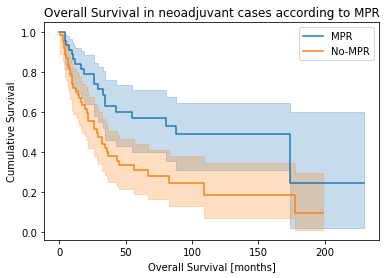

In [41]:
# Cases with MPR should have a better survival
ax_MPR = plt.subplot(111)

for name, grouped_df in df_study_survivalanalyses.groupby('MPR'):
    kmf.fit(grouped_df['OS'], grouped_df['STATOS'], label = name)
    kmf.plot_survival_function(ax = ax_MPR)
    plt.title('Overall Survival in neoadjuvant cases according to MPR')
    plt.xlabel('Overall Survival [months]')
    plt.ylabel('Cumulative Survival')
    

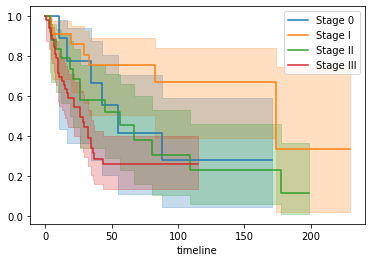

In [19]:
# Cases with lower stages should have better survival
ax_stage = plt.subplot(111)

for name, grouped_df in df_study_survivalanalyses.groupby('stage_short'):
    kmf.fit(grouped_df['OS'], grouped_df['STATOS'], label = name)
    kmf.plot_survival_function(ax = ax_stage)

Stage III    53
Stage II     26
Stage I      22
Stage 0      10
Name: stage_short, dtype: int64


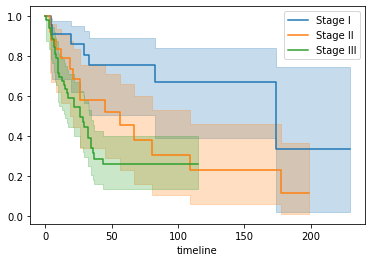

In [20]:
# The Stage 0 cases fall a little bit out of order... How many cases are there? More appropriate without Stage 0 cases?
print(df_study_survivalanalyses.stage_short.value_counts())
df_study_survivalanalyses_withoutStage0 = df_study_survivalanalyses[df_study_survivalanalyses['stage_short'] != 'Stage 0']
ax_stage_new = plt.subplot(111)

for name, grouped_df in df_study_survivalanalyses_withoutStage0.groupby('stage_short'):
    kmf.fit(grouped_df['OS'], grouped_df['STATOS'], label = name)
    kmf.plot_survival_function(ax = ax_stage_new)

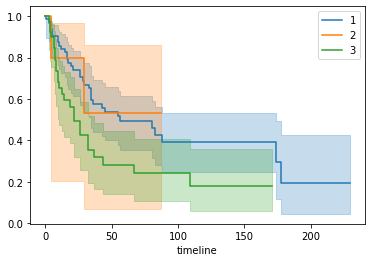

In [21]:
# Cases with less extensive resection should have better survival
ax_rtype = plt.subplot(111)

for name, grouped_df in df_study_survivalanalyses.groupby('rtype_short'):
    kmf.fit(grouped_df['OS'], grouped_df['STATOS'], label = name)
    kmf.plot_survival_function(ax = ax_rtype)

1    66
3    40
2     5
Name: rtype_short, dtype: int64


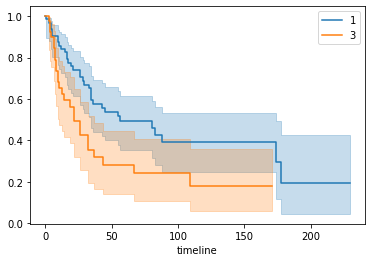

In [22]:
# Their seem to be much less bilobectomy cases. How much are their? Redo the Kaplan-Meier without considering Bilobectomy cases
print(df_study_survivalanalyses.rtype_short.value_counts())
df_study_survivalanalyses_withoutBilo = df_study_survivalanalyses[df_study_survivalanalyses['rtype_short'] != 2]
ax_rtype_new = plt.subplot(111)

for name, grouped_df in df_study_survivalanalyses_withoutBilo.groupby('rtype_short'):
    kmf.fit(grouped_df['OS'], grouped_df['STATOS'], label = name)
    kmf.plot_survival_function(ax = ax_rtype_new)

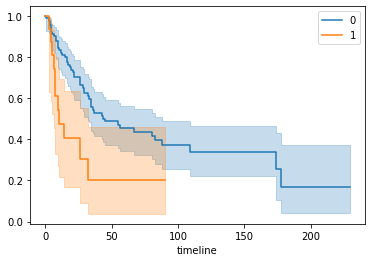

In [23]:
# Cases without residual tumor after surgery should have better survival
ax_R = plt.subplot(111)

for name, grouped_df in df_study_survivalanalyses.groupby('R_short'):
    kmf.fit(grouped_df['OS'], grouped_df['STATOS'], label = name)
    kmf.plot_survival_function(ax = ax_R)